In [1]:
%pip install pymssql

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt

In [3]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" # paste password between quote marks
database = "ghz"

string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [16]:
data = pd.read_sql(
    """
    select ticker, date, ret, roeq, mom12m, siccd, bm, gma, mom1m, cfp_ia
    from data
    where date>='2014-01'
    order by date, ticker
    """, 
    conn
)
data = data.dropna()

ff49 = pd.read_excel(r'C:\Users\Daniel\OneDrive\Documents\Jupyter Notebook\ff49.xlsx', index_col=0) #CHANGE THIS FOR YOUR COMPUTER
def industry(sic):
  try:
    return ff49[(ff49.lower<=sic)&(sic<=ff49.upper)].index[0]
  except:
    return "Almost Nothing"
    
data["industry"] = data.siccd.map(industry)

In [17]:
factors = pdr("F-F_Research_Data_Factors", "famafrench", start=2000)[0] / 100
factors = factors.reset_index()
factors["Date"] = factors["Date"].astype(str)

data = data.merge(factors, left_on="date", right_on="Date", how="left")
data["retx"] = data["ret"] - data["RF"] - data["Mkt-RF"]

In [18]:
data = data.rename(columns={"RF_x": "RF", "Mkt-RF_x" : "Mkt-RF"})
data["retx"] = data["ret"] - data["RF"] - data["Mkt-RF"]

In [19]:
transform1 = QuantileTransformer(
    output_distribution="normal"
)

transform2 = QuantileTransformer(
    output_distribution="normal"
)

transform3 = QuantileTransformer(
    output_distribution="normal"
)

poly = PolynomialFeatures(degree=2)

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=100,random_state=0, max_depth=5, n_jobs=-1),
    transformer=transform3
)

pipe = make_pipeline(
  transform1,
  poly,
  transform2,
  model
)

In [77]:
df = None #start with no dataframe
dates = data.date.unique() #gives unique dates with no repeats
train_dates = [d for d in dates if d>="2017-01" and d<"2022-03"] #retrain every month
start_dates = dates[0:62]
predict_dates = [d for d in dates if d>="2017-02"] 
for date in train_dates:
    start_date = start_dates[train_dates.index(date)]
    X = data[(data.date<=date) & (data.date>=start_date)][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]]
    y = data[(data.date<=date) & (data.date>=start_date)]["retx"]
    pipe.fit(X, y)
    predict_date = predict_dates[train_dates.index(date)]
    X = data[data.date==predict_date][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]] #present date
    out = pd.DataFrame(dtype=float, columns=["date", "ticker", "predict", "ret"])
    out["ticker"] = data[data.date==predict_date].ticker #ticker for each month
    out["predict"] = pipe.predict(X)
    out["date"] = predict_date
    out["ret"] = data[data.date==predict_date].ret 
    out["industry"] = data[data.date==predict_date].industry
    df = pd.concat((df, out)) #concatinate "None" with what we want "out"

In [78]:
for date in train_dates:
    start_date = start_dates[train_dates.index(date)]
    X = data[(data.date<=date) & (data.date>=start_date)][["date","roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]]
    y = data[(data.date<=date) & (data.date>=start_date)]["retx"]
    print(X.tail())

           date      roeq        bm       gma    mom12m     mom1m    cfp_ia
116865  2017-01 -0.427867  0.122803  0.000000 -0.290323  0.037879 -0.746630
116866  2017-01 -0.002652  0.737872  0.250063  0.067164 -0.101399  0.059433
116867  2017-01  0.009417  0.230367  0.269035 -0.118656 -0.027170 -0.015984
116868  2017-01  0.192275  0.044807  0.492357  0.059892  0.062525  0.361103
116869  2017-01 -0.002897  0.637833  0.549036  0.640212 -0.118952  0.142796
           date      roeq        bm       gma    mom12m     mom1m    cfp_ia
120012  2017-02 -0.427867  0.122803  0.000000 -0.255435 -0.043796 -0.746630
120013  2017-02 -0.002652  0.737872  0.250063  0.044715 -0.019455  0.059433
120014  2017-02  0.009417  0.230367  0.269035 -0.136429 -0.090038 -0.015984
120015  2017-02  0.192275  0.044807  0.492357  0.250798  0.028302  0.361103
120016  2017-02 -0.002897  0.637833  0.549036  0.206516 -0.082380  0.142796
           date      roeq        bm       gma    mom12m     mom1m    cfp_ia
123146  2017

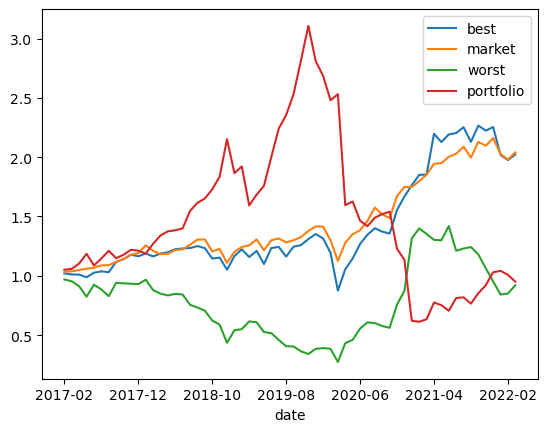

In [79]:
df["rnk"] = df.groupby("date").predict.rank(method="first", ascending=False) #method="first" is used to break ties alphabetically
best = df[df.rnk<=100] #rank the 100 best performing stocks

df["rnk"] = df.groupby("date").predict.rank(method="first")
worst = df[df.rnk<100] #rank the 100 worst performing stocks

data["Market"] = data["Mkt-RF"]
mkt = data[data.date>"2017-01"][["date", "Market"]]
sp = mkt.groupby("date").Market.mean()
best_rets = best.groupby("date").ret.mean() #form portfolio of returns
worst_rets = worst.groupby("date").ret.mean() #form portfolio of returns
port_rets = best_rets - worst_rets

(1+best_rets).cumprod().plot(label="best") #cumulative return of top 100 stocks
(1+sp).cumprod().plot(label="market")
(1+worst_rets).cumprod().plot(label="worst") #cumulative return of the bottom 100 stocks
(1+port_rets).cumprod().plot(label="portfolio") #cumulative return of the portfolio
plt.legend()

In [80]:
transform1 = QuantileTransformer(
    output_distribution="normal"
)

transform2 = QuantileTransformer(
    output_distribution="normal"
)

transform3 = QuantileTransformer(
    output_distribution="normal"
)

poly = PolynomialFeatures(degree=2)

model2 = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(max_depth=5, learning_rate=0.1, loss='huber', random_state=0),
    transformer=transform3
)

pipe2 = make_pipeline(
  transform1,
  poly,
  transform2,
  model2
)

In [81]:
df2 = None #start with no dataframe
for date in train_dates:
    start_date = start_dates[train_dates.index(date)]
    X = data[(data.date<=date) & (data.date>=start_date)][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]]
    y = data[(data.date<=date) & (data.date>=start_date)]["retx"]
    pipe2.fit(X, y)
    predict_date = predict_dates[train_dates.index(date)]
    X = data[data.date==predict_date][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]] #present date
    out2 = pd.DataFrame(dtype=float, columns=["date", "ticker", "predict", "ret"])
    out2["ticker"] = data[data.date==predict_date].ticker #ticker for each month
    out2["predict"] = pipe2.predict(X)
    out2["date"] = predict_date
    out2["ret"] = data[data.date==predict_date].ret 
    out2["industry"] = data[data.date==predict_date].industry
    df2 = pd.concat((df2, out2)) #concatinate "None" with what we want "out"
     

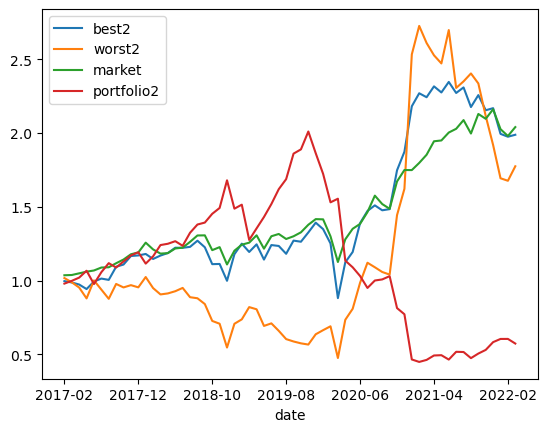

In [83]:
df2["rnk"] = df2.groupby("date").predict.rank(method="first", ascending=False) #method="first" is used to break ties alphabetically
best2 = df2[df2.rnk<=100] #rank the 100 best performing stocks

df2["rnk"] = df2.groupby("date").predict.rank(method="first")
worst2 = df2[df2.rnk<100] #rank the 100 worst performing stocks

best_rets2 = best2.groupby("date").ret.mean() #form portfolio of returns
worst_rets2 = worst2.groupby("date").ret.mean() #form portfolio of returns
port_rets2 = best_rets2 - worst_rets2

(1+best_rets2).cumprod().plot(label="best2") #cumulative return of top 100 stocks
(1+worst_rets2).cumprod().plot(label="worst2") #cumulative return of the bottom 100 stocks
(1+sp).cumprod().plot(label="market")
(1+port_rets2).cumprod().plot(label="portfolio2") #cumulative return of the portfolio
plt.legend()

In [102]:
transform1 = QuantileTransformer(
    output_distribution="normal"
)

transform2 = QuantileTransformer(
    output_distribution="normal"
)

transform3 = QuantileTransformer(
    output_distribution="normal"
)

poly = PolynomialFeatures(degree=2)

model3 = TransformedTargetRegressor(
    regressor=MLPRegressor(hidden_layer_sizes=(16,8,4,2), random_state=0),
    transformer=transform3
)


pipe3 = make_pipeline(
  transform1,
  poly,
  transform2,
  model3
)

In [103]:
df3 = None #start with no dataframe
dates = data.date.unique() #gives unique dates with no repeats
train_dates = [d for d in dates if d>="2017-01" and d<"2022-03"] #retrain every month
for date in train_dates:
    start_date = start_dates[train_dates.index(date)]
    X = data[(data.date<=date) & (data.date>=start_date)][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]]
    y = data[(data.date<=date) & (data.date>=start_date)]["retx"]
    pipe3.fit(X, y)
    predict_date = predict_dates[train_dates.index(date)]
    X = data[data.date==predict_date][["roeq", "bm", "gma", "mom12m", "mom1m", "cfp_ia"]] #present date
    out3 = pd.DataFrame(dtype=float, columns=["date", "ticker", "predict", "ret"])
    out3["ticker"] = data[data.date==predict_date].ticker #ticker for each month
    out3["predict"] = pipe3.predict(X)
    out3["date"] = predict_date
    out3["ret"] = data[data.date==predict_date].ret 
    out3["industry"] = data[data.date==predict_date].industry
    df3 = pd.concat((df3, out3)) #concatinate "None" with what we want "out"
     

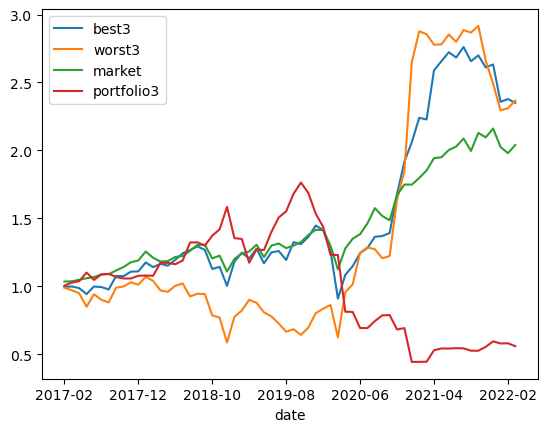

In [108]:
df3["rnk"] = df3.groupby("date").predict.rank(method="first", ascending=False) #method="first" is used to break ties alphabetically
best3 = df3[df3.rnk<=100] #rank the 100 best performing stocks

df3["rnk"] = df3.groupby("date").predict.rank(method="first")
worst3 = df3[df3.rnk<100] #rank the 100 worst performing stocks

best_rets3 = best3.groupby("date").ret.mean() #form portfolio of returns
worst_rets3 = worst3.groupby("date").ret.mean() #form portfolio of returns
port_rets3 = best_rets3 - worst_rets3

(1+best_rets3).cumprod().plot(label="best3") #cumulative return of top 100 stocks
(1+worst_rets3).cumprod().plot(label="worst3") #cumulative return of the bottom 100 stocks
(1+sp).cumprod().plot(label="market")
(1+port_rets3).cumprod().plot(label="portfolio3") #cumulative return of the portfolio
plt.legend()

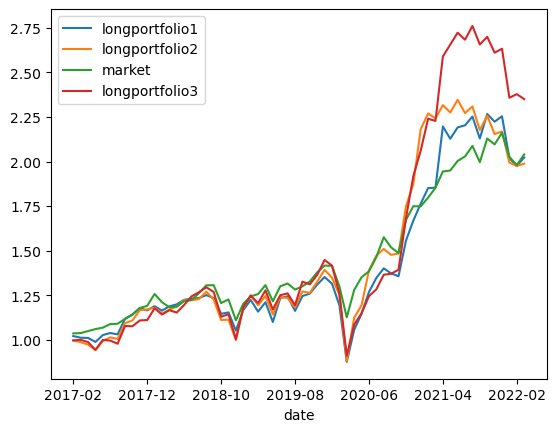

In [112]:
(1+best_rets).cumprod().plot(label="longportfolio1") 
(1+best_rets2).cumprod().plot(label="longportfolio2") 
(1+sp).cumprod().plot(label="market")
(1+best_rets3).cumprod().plot(label="longportfolio3") 
plt.legend()